In [1]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
from neurorient import NeurOrient
from neurorient.utils_visualization import save_mrc
from neurorient.reconstruction.phasing import PhaseRetriever


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
spi_data = torch.load('/pscratch/sd/z/zhantao/neurorient_repo/data/1BXR_increase10_poissonFalse_num10K.pt')
model_dir = '/pscratch/sd/z/zhantao/neurorient_repo/model'
print(spi_data.keys())

dict_keys(['orientations', 'intensities', 'pixel_position_reciprocal', 'pixel_index_map', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [4]:
model = NeurOrient.load_from_checkpoint(
    '/pscratch/sd/z/zhantao/neurorient_repo/model/lightning_logs/version_14729080/checkpoints/last.ckpt')

In [5]:
model.to(device);

In [6]:
slices_true = spi_data['intensities'][:10]
slices_target = torch.log(slices_true * 10 + 1).unsqueeze(1)

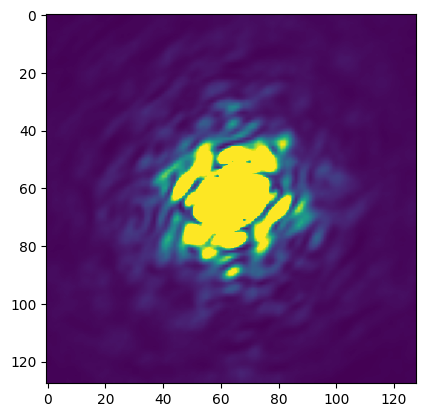

In [7]:
from neurorient.reconstruction.slicing import gen_nonuniform_normalized_positions

with torch.no_grad():
    orientations = model.image_to_orientation(slices_target.to(device))
    # get reciprocal positions based on orientations
    # HKL has shape (3, num_qpts)
    HKL = gen_nonuniform_normalized_positions(
        orientations, model.pixel_position_reciprocal, model.over_sampling)
    # predict slices from HKL
    slices_pred = model.predict_slice(HKL).view((-1, 1,) + (model.image_dimension,)*2)
    
slices_pred = torch.exp(slices_pred)
plt.imshow(slices_pred[3,0].detach().cpu(), vmax=slices_pred.max() * 1e-3)

In [22]:
import numpy as np

model.to(device)

grid_reciprocal = model.grid_position_reciprocal / model.grid_position_reciprocal.max()
with torch.no_grad():
    intensity = model.predict_intensity(np.pi * grid_reciprocal.to(device))
intensity_pred = torch.exp(intensity)

In [18]:
phase_retriever = PhaseRetriever(n_phase_loops=30, beta=0.5)
rho_phased, support_phased = phase_retriever.phase(intensity_pred.sqrt().to('cuda'))

Phase Retrieval: 100%|██████████| 30/30 [00:02<00:00, 10.21it/s]


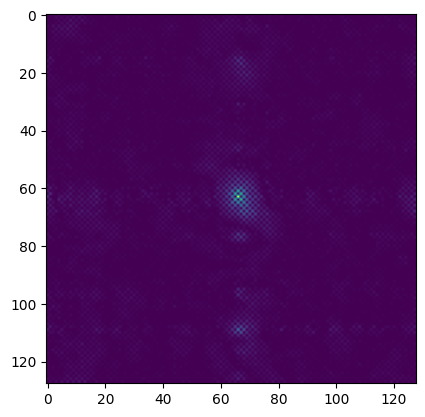

In [20]:
plt.imshow(rho_phased[64].clip(0).cpu())

In [21]:
save_mrc('1bxr.mrc', rho_phased.detach().cpu().numpy())